In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 19), reused 60 (delta 14), pack-reused 0
Receiving objects: 100% (65/65), 2.09 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [4]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [5]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [6]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"


In [7]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [8]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [9]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 294.44it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:13<00:00, 542.08it/s]


(7178, 224, 224, 3)
(7178, 2)


## load model

In [10]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [11]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_out"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_out"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_out"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])

234698864/234698864 [==============================] - 12s 0us/step
Running time: 19.6394 seconds
171446536/171446536 [==============================] - 8s 0us/step
Running time: 11.1431 seconds
94765736/94765736 [==============================] - 5s 0us/step
Running time: 7.0585 seconds
Running time: 4.9418 seconds
Running time: 3.1871 seconds
Running time: 1.7001 seconds


In [12]:
# # best model calculate before the notebook crashed
# model_resnet_152_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_full/weights.08-0.00-1.00.hdf5")
# model_resnet_101_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_full/weights.10-0.00-1.00.hdf5")
# model_resnet_50_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_full/weights.06-0.00-1.00.hdf5")
# model_resnet_152_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_freeze/weights.02-0.24-0.95.hdf5")
# model_resnet_101_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_freeze/weights.02-0.71-0.48.hdf5")
# model_resnet_50_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_freeze/weights.02-0.66-0.62.hdf5")

In [13]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

## Resnet Training

__________ 152_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 32s 149ms/step - loss: 0.8348 - accuracy: 0.6970 - val_loss: 0.9450 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 8s 93ms/step - loss: 0.4347 - accuracy: 0.8102 - val_loss: 0.8367 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 8s 93ms/step - loss: 0.3873 - accuracy: 0.8305 - val_loss: 0.4471 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 7s 76ms/step - loss: 0.3535 - accuracy: 0.8455 - val_loss: 0.5869 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 7s 77ms/step - loss: 0.3169 - accuracy: 0.8628 - val_loss: 0.5554 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 7s 76ms/step - loss: 0.3070 - accuracy: 0.8643 - val_loss: 0.5670 - val_accuracy: 0.7256 - lr: 0.0010
Epo

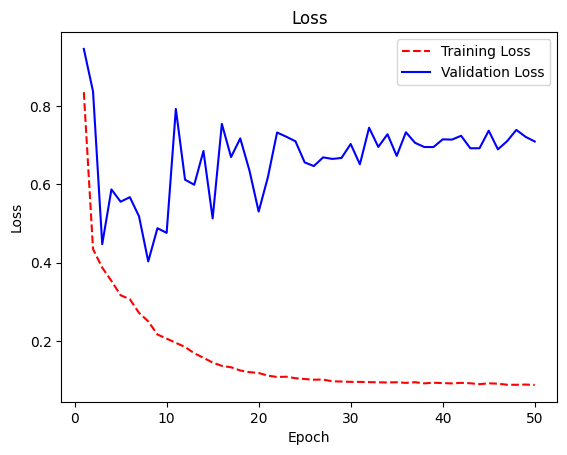

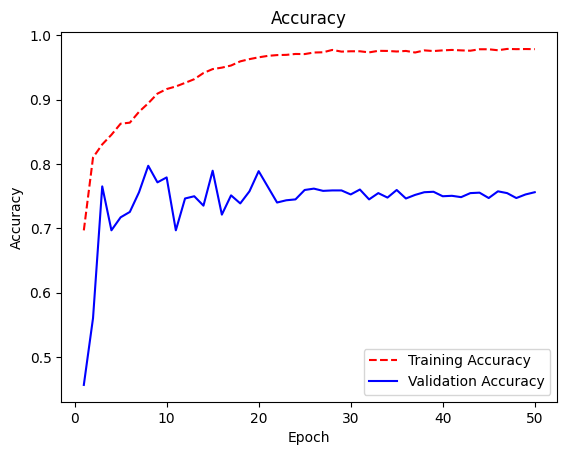

Epoch: 8
loss:0.25
accuracy:0.89
val_loss:0.4
val_accuracy:0.8
lr:0.0
__________ 101_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 16s 107ms/step - loss: 0.7734 - accuracy: 0.5810 - val_loss: 1.1373 - val_accuracy: 0.0063 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 6s 71ms/step - loss: 0.6601 - accuracy: 0.6198 - val_loss: 0.7531 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6425 - accuracy: 0.6343 - val_loss: 0.8314 - val_accuracy: 0.3454 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6413 - accuracy: 0.6310 - val_loss: 1.1058 - val_accuracy: 0.0717 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6331 - accuracy: 0.6412 - val_loss: 0.8396 - val_accuracy: 0.3064 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6288 - accur

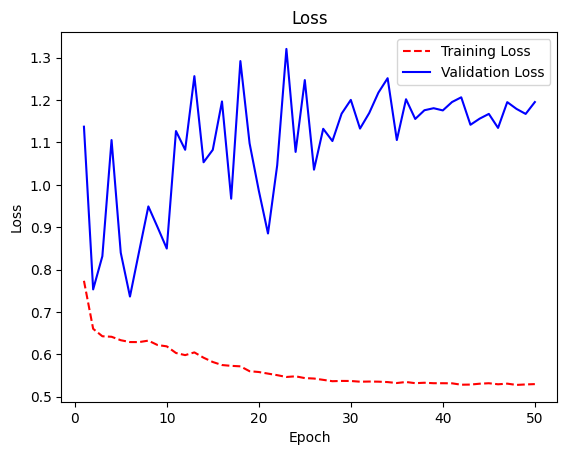

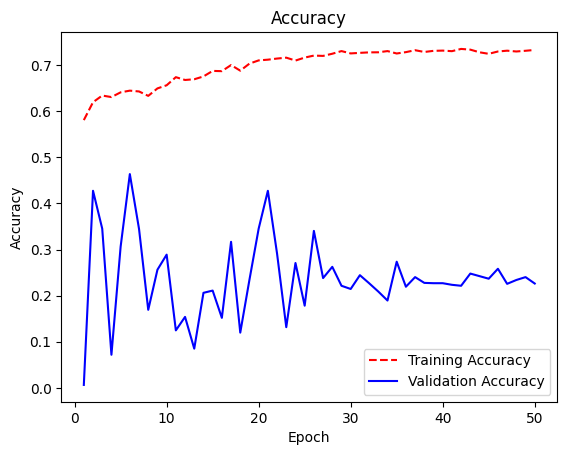

Epoch: 6
loss:0.63
accuracy:0.64
val_loss:0.74
val_accuracy:0.46
lr:0.0
__________ 50_full __________________________________________________
Epoch 1/50
90/90 [==============================] - 11s 82ms/step - loss: 0.8059 - accuracy: 0.5832 - val_loss: 1.1763 - val_accuracy: 0.0091 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6544 - accuracy: 0.6221 - val_loss: 0.7684 - val_accuracy: 0.3948 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6373 - accuracy: 0.6331 - val_loss: 0.8521 - val_accuracy: 0.2918 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6358 - accuracy: 0.6404 - val_loss: 1.0977 - val_accuracy: 0.0940 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6268 - accuracy: 0.6421 - val_loss: 0.7587 - val_accuracy: 0.4540 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6278 - accur

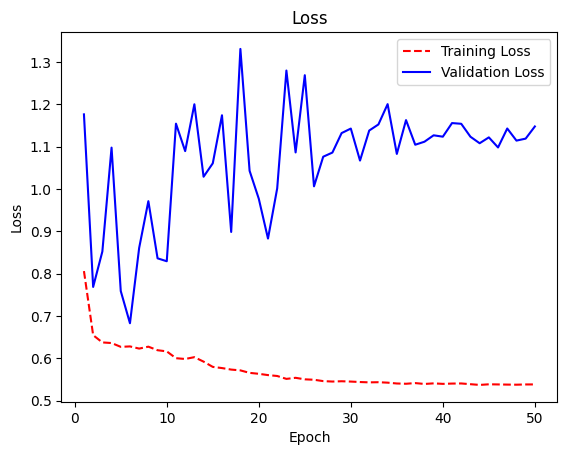

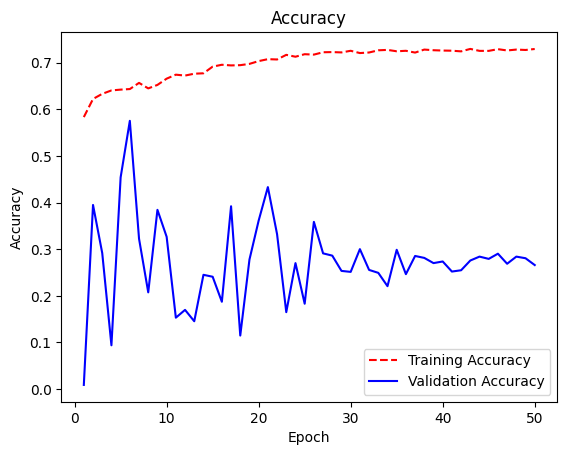

Epoch: 6
loss:0.63
accuracy:0.64
val_loss:0.68
val_accuracy:0.58
lr:0.0
__________ 152_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 21s 132ms/step - loss: 0.7051 - accuracy: 0.7226 - val_loss: 0.9144 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 8s 91ms/step - loss: 0.4024 - accuracy: 0.8227 - val_loss: 0.7749 - val_accuracy: 0.6031 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 8s 93ms/step - loss: 0.3581 - accuracy: 0.8413 - val_loss: 0.5762 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 7s 77ms/step - loss: 0.3358 - accuracy: 0.8541 - val_loss: 0.8708 - val_accuracy: 0.5989 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 8s 93ms/step - loss: 0.2845 - accuracy: 0.8760 - val_loss: 0.4928 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 8s 92ms/step - loss: 0.2915 - a

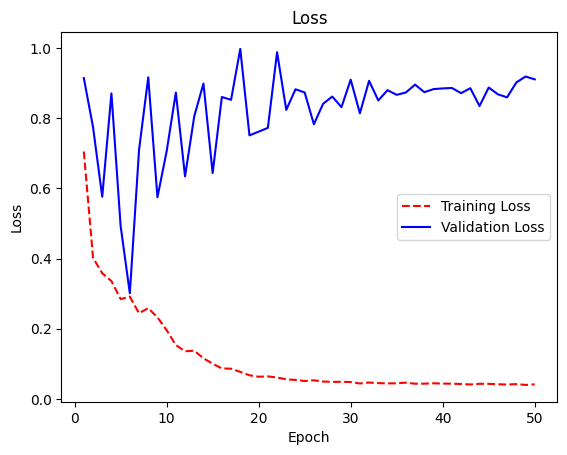

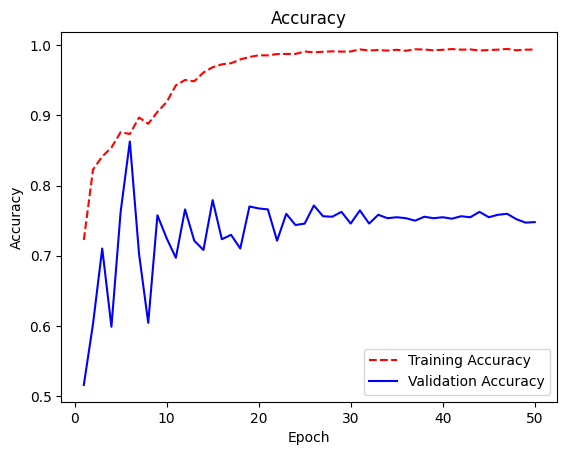

Epoch: 6
loss:0.29
accuracy:0.87
val_loss:0.3
val_accuracy:0.86
lr:0.0
__________ 101_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 16s 105ms/step - loss: 0.7964 - accuracy: 0.5852 - val_loss: 1.0405 - val_accuracy: 0.0097 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6587 - accuracy: 0.6177 - val_loss: 0.8691 - val_accuracy: 0.1560 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 6s 72ms/step - loss: 0.6439 - accuracy: 0.6266 - val_loss: 0.8019 - val_accuracy: 0.3747 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 5s 60ms/step - loss: 0.6391 - accuracy: 0.6358 - val_loss: 1.1122 - val_accuracy: 0.0467 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 5s 59ms/step - loss: 0.6351 - accuracy: 0.6412 - val_loss: 0.8272 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 6s 70ms/step - loss: 0.6298 - ac

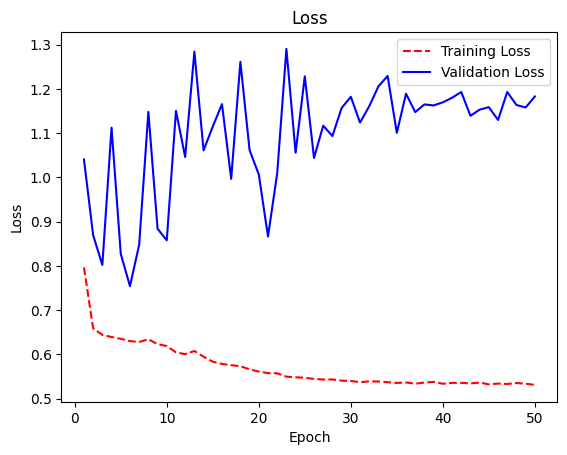

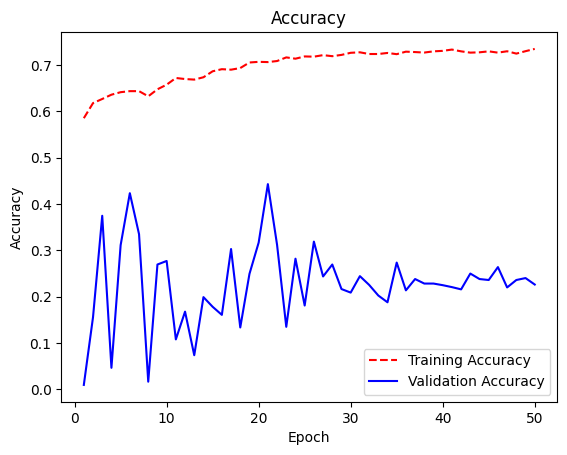

Epoch: 6
loss:0.63
accuracy:0.64
val_loss:0.75
val_accuracy:0.42
lr:0.0
__________ 50_freeze __________________________________________________
Epoch 1/50
90/90 [==============================] - 10s 74ms/step - loss: 0.7528 - accuracy: 0.5951 - val_loss: 1.2318 - val_accuracy: 0.0077 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6528 - accuracy: 0.6212 - val_loss: 0.8017 - val_accuracy: 0.3384 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - 4s 50ms/step - loss: 0.6368 - accuracy: 0.6374 - val_loss: 0.7962 - val_accuracy: 0.3872 - lr: 0.0010
Epoch 4/50
90/90 [==============================] - 4s 44ms/step - loss: 0.6350 - accuracy: 0.6364 - val_loss: 1.0303 - val_accuracy: 0.1546 - lr: 0.0010
Epoch 5/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6297 - accuracy: 0.6468 - val_loss: 0.7480 - val_accuracy: 0.4645 - lr: 0.0010
Epoch 6/50
90/90 [==============================] - 4s 49ms/step - loss: 0.6245 - acc

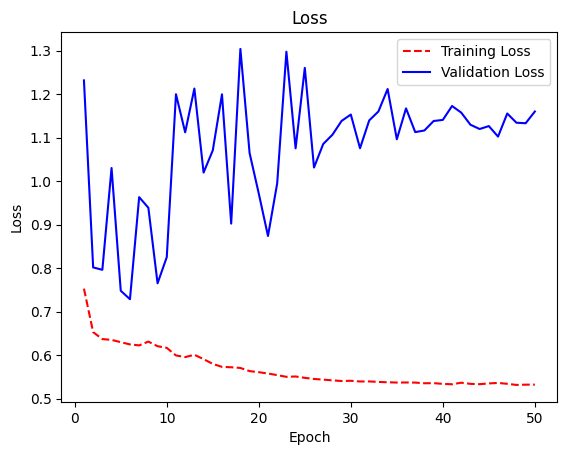

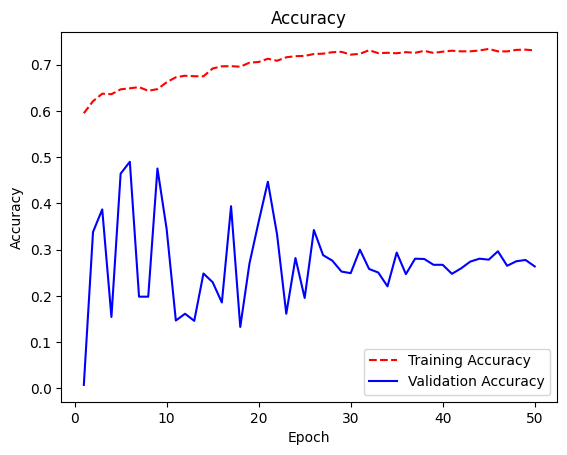

Epoch: 6
loss:0.62
accuracy:0.65
val_loss:0.73
val_accuracy:0.49
lr:0.0


In [14]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=50, validation_split=0.2)
  tf.keras.backend.clear_session()

In [15]:
# for key in model_softmax.keys():
#   model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Training

In [16]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [17]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [18]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 152_full __________
classifier train accuracy: 0.863889662858735
classifier running time: 0.03660154342651367
__________ 101_full __________
classifier train accuracy: 0.5794093062134299
classifier running time: 0.015949726104736328
__________ 50_full __________
classifier train accuracy: 0.6173028698801895
classifier running time: 0.018790721893310547
__________ 152_freeze __________
classifier train accuracy: 0.7751462803009195
classifier running time: 0.015155553817749023
__________ 101_freeze __________
classifier train accuracy: 0.6012816940651993
classifier running time: 0.015301942825317383
__________ 50_freeze __________
classifier train accuracy: 0.6054611312343271
classifier running time: 0.015516042709350586


## Svm Training

In [19]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 152_full __________
Classifier train accuracy: 0.9146001671774867
__________ 101_full __________
Classifier train accuracy: 0.638757314015046
__________ 50_full __________
Classifier train accuracy: 0.6416829200334355
__________ 152_freeze __________
Classifier train accuracy: 0.9143215380328782
__________ 101_freeze __________
Classifier train accuracy: 0.6372248537196991
__________ 50_freeze __________
Classifier train accuracy: 0.6401504597380886


In [20]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [21]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 217.57it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 235.87it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 222.76it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 316.03it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 325.80it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 304.11it/s]


## Testing Resnet

In [22]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result[... ,0] < 0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

__________ 152_full __________
__________gen__________
Accuracy 0.758
Precision: 0.704000
Recall: 0.789238
F1 score: 0.744186
__________ec__________
Accuracy 0.9
Precision: 0.988000
Recall: 0.840136
F1 score: 0.908088
__________vqvae__________
Accuracy 0.883
Precision: 0.954000
Recall: 0.835377
F1 score: 0.890756
__________ 101_full __________
__________gen__________
Accuracy 0.56
Precision: 0.464000
Recall: 0.574257
F1 score: 0.513274
__________ec__________
Accuracy 0.68
Precision: 0.704000
Recall: 0.671756
F1 score: 0.687500
__________vqvae__________
Accuracy 0.537
Precision: 0.418000
Recall: 0.548556
F1 score: 0.474461
__________ 50_full __________
__________gen__________
Accuracy 0.582
Precision: 0.564000
Recall: 0.585062
F1 score: 0.574338
__________ec__________
Accuracy 0.699
Precision: 0.798000
Recall: 0.666110
F1 score: 0.726115
__________vqvae__________
Accuracy 0.553
Precision: 0.506000
Recall: 0.558499
F1 score: 0.530955
__________ 152_freeze __________
__________gen________

## Testing ELM

__________ 152_full __________
__________gen__________
Accuracy 0.743
Precision: 0.714000
Recall: 0.757962
F1 score: 0.735324


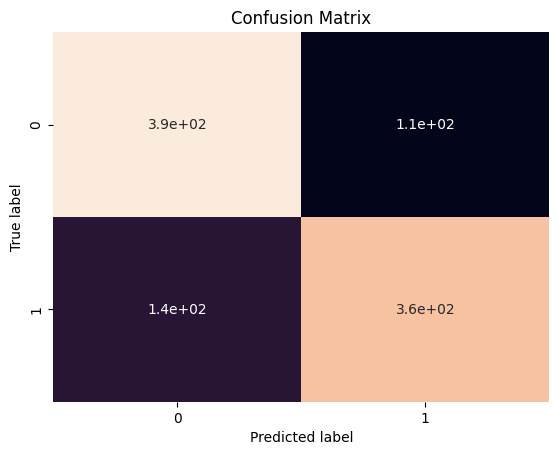

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       500
           1       0.76      0.71      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

__________ec__________
Accuracy 0.882
Precision: 0.992000
Recall: 0.813115
F1 score: 0.893694


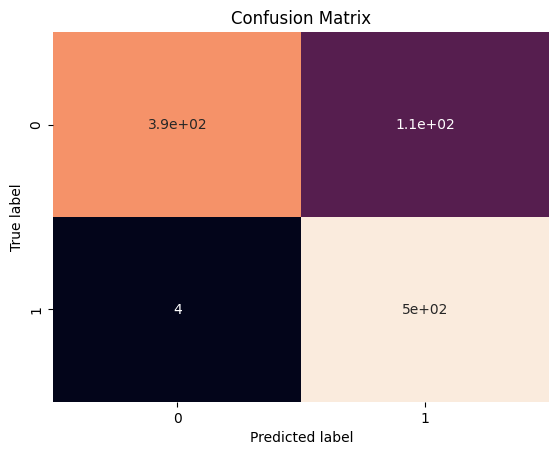

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       500
           1       0.81      0.99      0.89       500

    accuracy                           0.88      1000
   macro avg       0.90      0.88      0.88      1000
weighted avg       0.90      0.88      0.88      1000

__________vqvae__________
Accuracy 0.857
Precision: 0.942000
Recall: 0.805128
F1 score: 0.868203


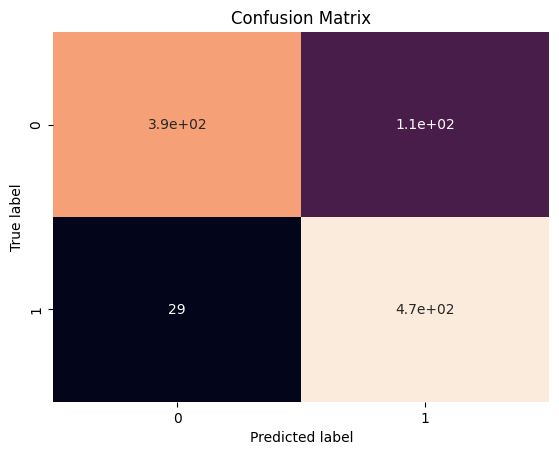

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       500
           1       0.81      0.94      0.87       500

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

__________ 101_full __________
__________gen__________
Accuracy 0.55
Precision: 0.532000
Recall: 0.551867
F1 score: 0.541752


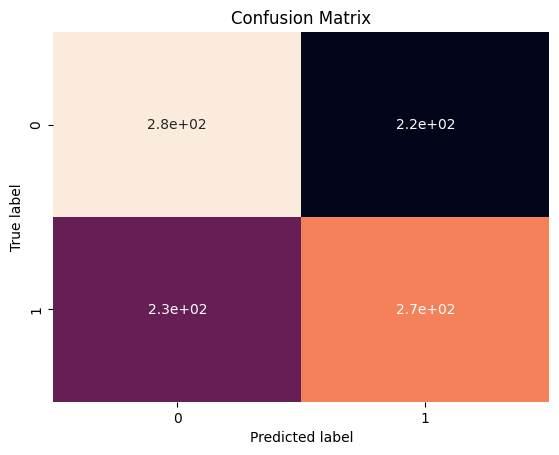

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       500
           1       0.55      0.53      0.54       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

__________ec__________
Accuracy 0.633
Precision: 0.698000
Recall: 0.617699
F1 score: 0.655399


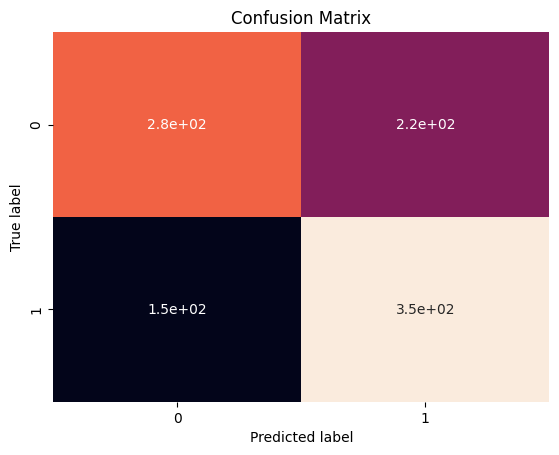

              precision    recall  f1-score   support

           0       0.65      0.57      0.61       500
           1       0.62      0.70      0.66       500

    accuracy                           0.63      1000
   macro avg       0.64      0.63      0.63      1000
weighted avg       0.64      0.63      0.63      1000

__________vqvae__________
Accuracy 0.543
Precision: 0.518000
Recall: 0.545263
F1 score: 0.531282


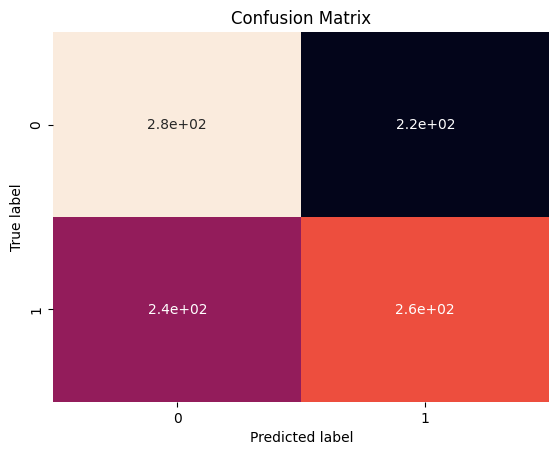

              precision    recall  f1-score   support

           0       0.54      0.57      0.55       500
           1       0.55      0.52      0.53       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

__________ 50_full __________
__________gen__________
Accuracy 0.562
Precision: 0.510000
Recall: 0.569196
F1 score: 0.537975


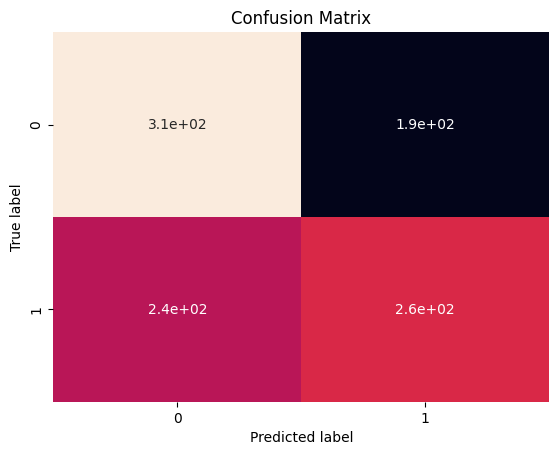

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       500
           1       0.57      0.51      0.54       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000

__________ec__________
Accuracy 0.697
Precision: 0.780000
Recall: 0.668954
F1 score: 0.720222


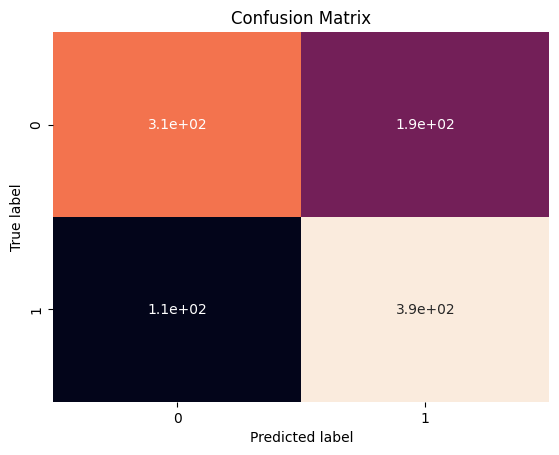

              precision    recall  f1-score   support

           0       0.74      0.61      0.67       500
           1       0.67      0.78      0.72       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.69      1000
weighted avg       0.70      0.70      0.69      1000

__________vqvae__________
Accuracy 0.543
Precision: 0.472000
Recall: 0.550117
F1 score: 0.508073


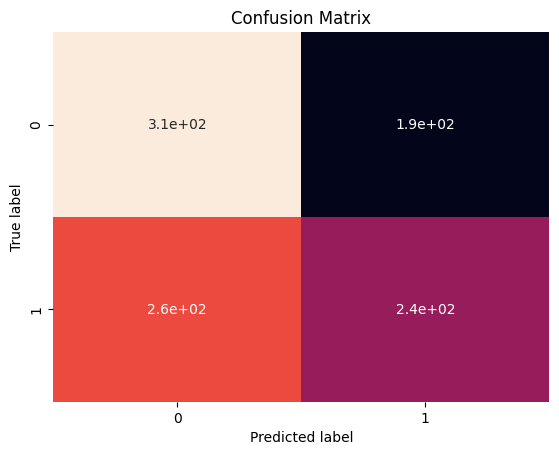

              precision    recall  f1-score   support

           0       0.54      0.61      0.57       500
           1       0.55      0.47      0.51       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

__________ 152_freeze __________
__________gen__________
Accuracy 0.684
Precision: 0.622000
Recall: 0.710046
F1 score: 0.663113


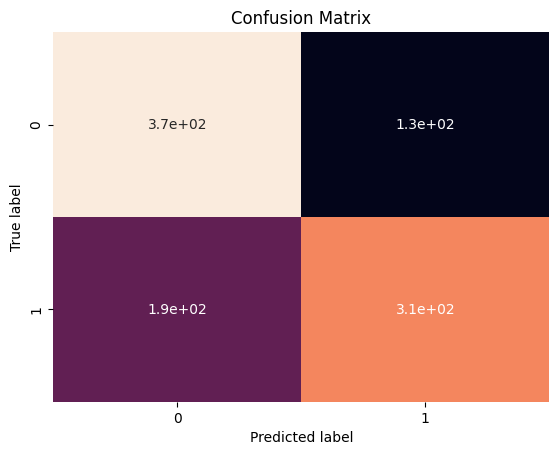

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       500
           1       0.71      0.62      0.66       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000

__________ec__________
Accuracy 0.804
Precision: 0.862000
Recall: 0.772401
F1 score: 0.814745


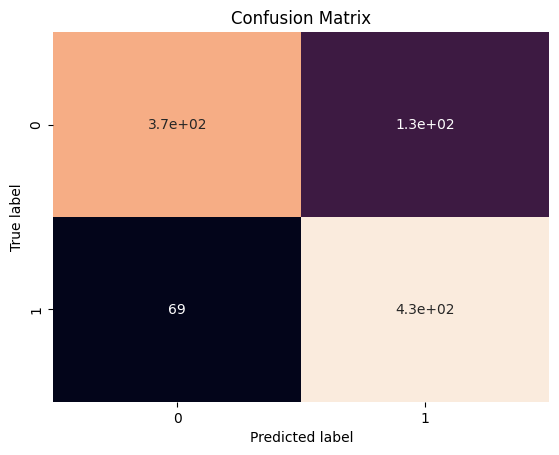

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       500
           1       0.77      0.86      0.81       500

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000

__________vqvae__________
Accuracy 0.84
Precision: 0.934000
Recall: 0.786195
F1 score: 0.853748


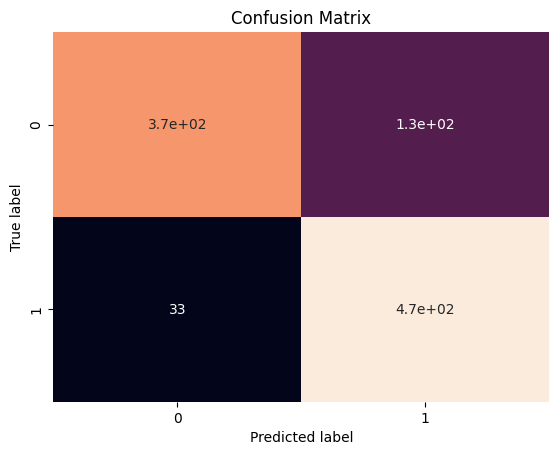

              precision    recall  f1-score   support

           0       0.92      0.75      0.82       500
           1       0.79      0.93      0.85       500

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000

__________ 101_freeze __________
__________gen__________
Accuracy 0.567
Precision: 0.574000
Recall: 0.566075
F1 score: 0.570010


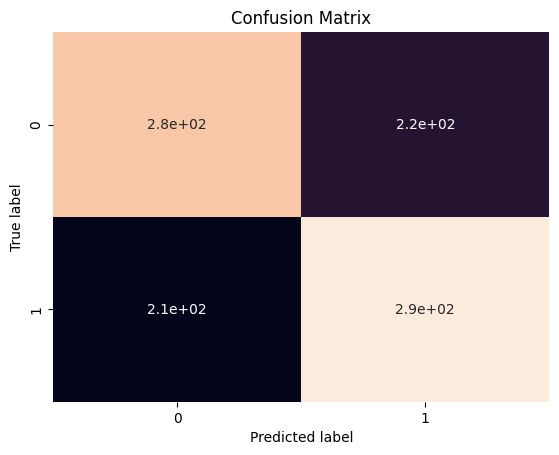

              precision    recall  f1-score   support

           0       0.57      0.56      0.56       500
           1       0.57      0.57      0.57       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ec__________
Accuracy 0.648
Precision: 0.736000
Recall: 0.625850
F1 score: 0.676471


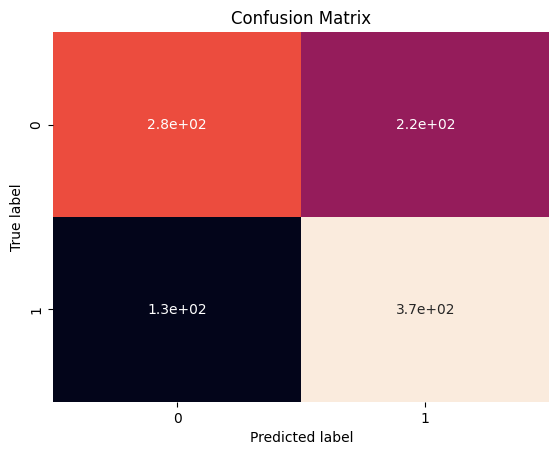

              precision    recall  f1-score   support

           0       0.68      0.56      0.61       500
           1       0.63      0.74      0.68       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

__________vqvae__________
Accuracy 0.527
Precision: 0.494000
Recall: 0.528908
F1 score: 0.510858


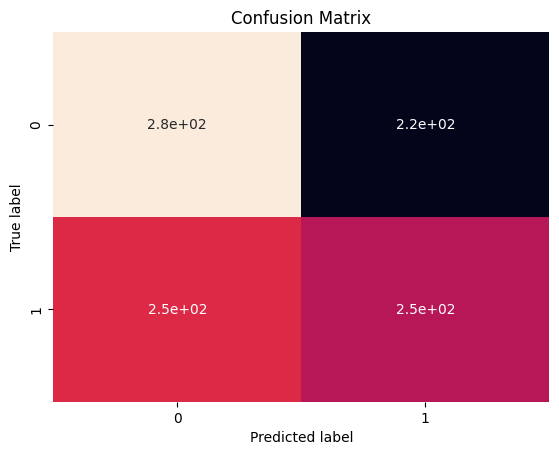

              precision    recall  f1-score   support

           0       0.53      0.56      0.54       500
           1       0.53      0.49      0.51       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000

__________ 50_freeze __________
__________gen__________
Accuracy 0.55
Precision: 0.572000
Recall: 0.547893
F1 score: 0.559687


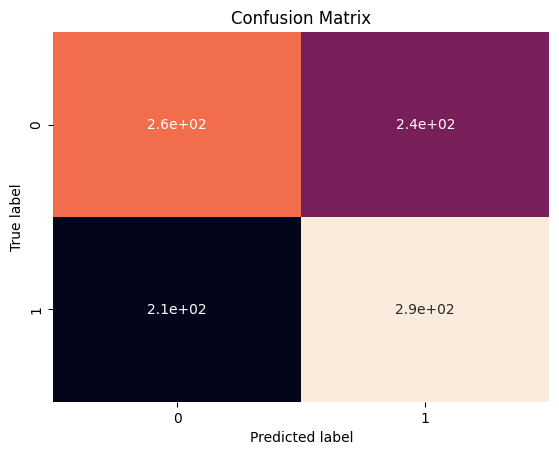

              precision    recall  f1-score   support

           0       0.55      0.53      0.54       500
           1       0.55      0.57      0.56       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

__________ec__________
Accuracy 0.661
Precision: 0.794000
Recall: 0.627172
F1 score: 0.700794


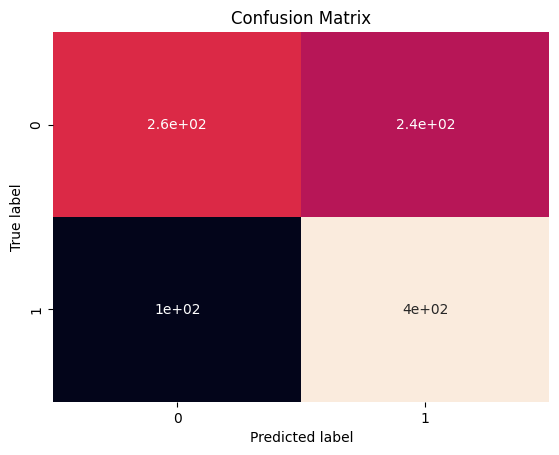

              precision    recall  f1-score   support

           0       0.72      0.53      0.61       500
           1       0.63      0.79      0.70       500

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.65      1000
weighted avg       0.67      0.66      0.65      1000

__________vqvae__________
Accuracy 0.541
Precision: 0.554000
Recall: 0.539961
F1 score: 0.546890


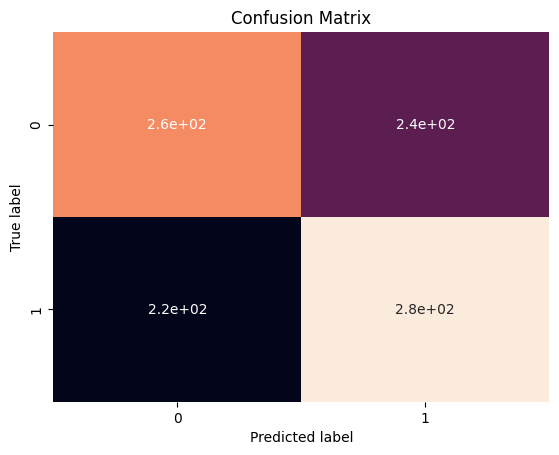

              precision    recall  f1-score   support

           0       0.54      0.53      0.53       500
           1       0.54      0.55      0.55       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



In [23]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))

## Testing SVM

__________ 152_full __________
__________gen__________
Accuracy 0.762
Precision: 0.682000
Recall: 0.811905
F1 score: 0.741304


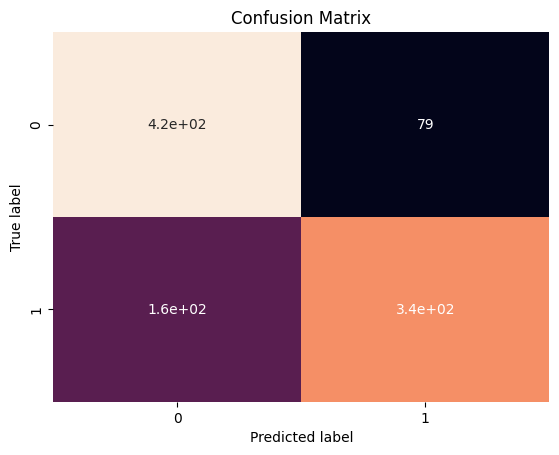

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       500
           1       0.81      0.68      0.74       500

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000

__________ec__________
Accuracy 0.916
Precision: 0.990000
Recall: 0.862369
F1 score: 0.921788


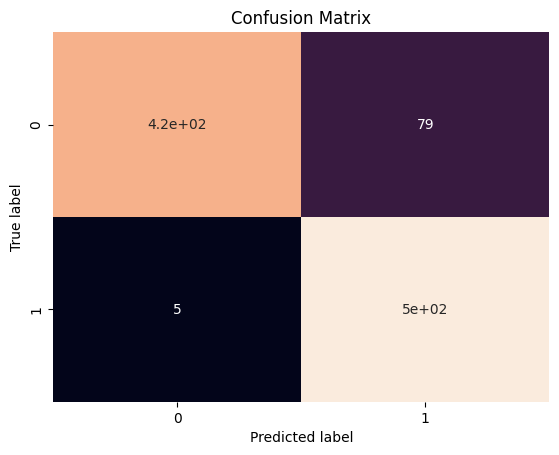

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       500
           1       0.86      0.99      0.92       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

__________vqvae__________
Accuracy 0.893
Precision: 0.944000
Recall: 0.856624
F1 score: 0.898192


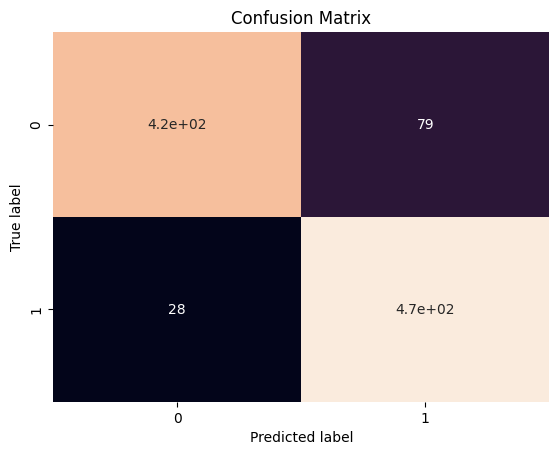

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       500
           1       0.86      0.94      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000

__________ 101_full __________
__________gen__________
Accuracy 0.573
Precision: 0.530000
Recall: 0.579869
F1 score: 0.553814


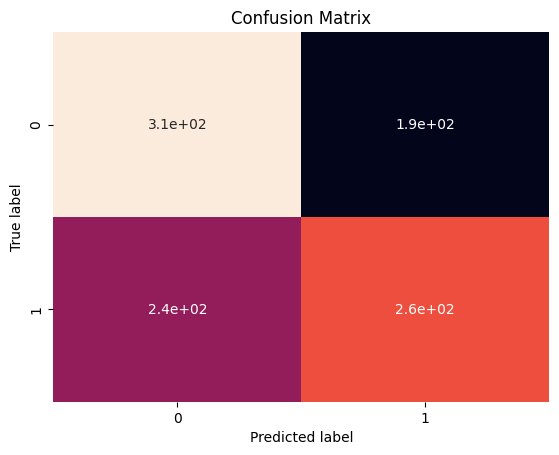

              precision    recall  f1-score   support

           0       0.57      0.62      0.59       500
           1       0.58      0.53      0.55       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ec__________
Accuracy 0.699
Precision: 0.782000
Recall: 0.670669
F1 score: 0.722068


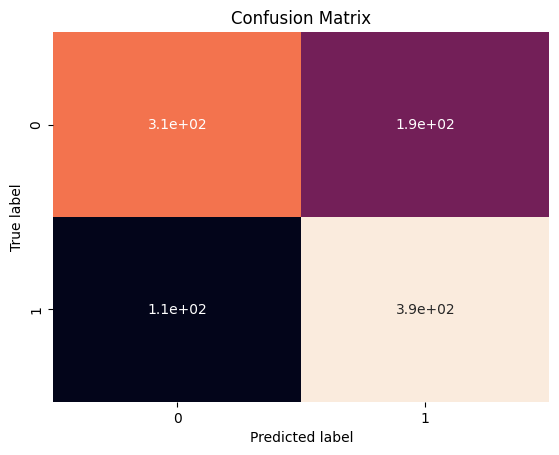

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       500
           1       0.67      0.78      0.72       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

__________vqvae__________
Accuracy 0.547
Precision: 0.478000
Recall: 0.554524
F1 score: 0.513426


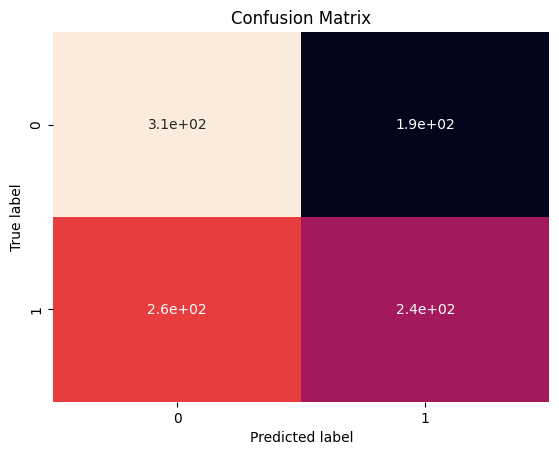

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       500
           1       0.55      0.48      0.51       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.54      1000
weighted avg       0.55      0.55      0.54      1000

__________ 50_full __________
__________gen__________
Accuracy 0.588
Precision: 0.518000
Recall: 0.602326
F1 score: 0.556989


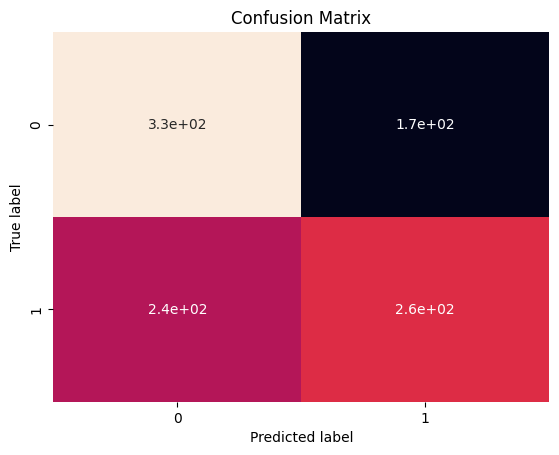

              precision    recall  f1-score   support

           0       0.58      0.66      0.61       500
           1       0.60      0.52      0.56       500

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000

__________ec__________
Accuracy 0.726
Precision: 0.794000
Recall: 0.698944
F1 score: 0.743446


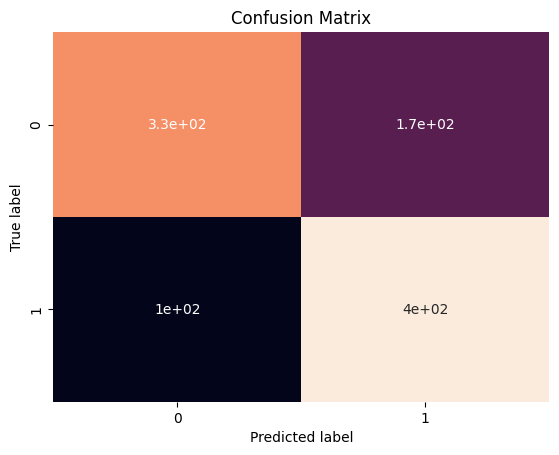

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       500
           1       0.70      0.79      0.74       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.72      1000
weighted avg       0.73      0.73      0.72      1000

__________vqvae__________
Accuracy 0.567
Precision: 0.476000
Recall: 0.581907
F1 score: 0.523652


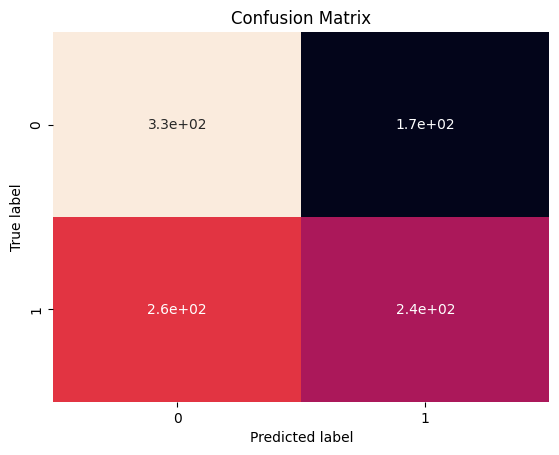

              precision    recall  f1-score   support

           0       0.56      0.66      0.60       500
           1       0.58      0.48      0.52       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000

__________ 152_freeze __________
__________gen__________
Accuracy 0.764
Precision: 0.694000
Recall: 0.806977
F1 score: 0.746237


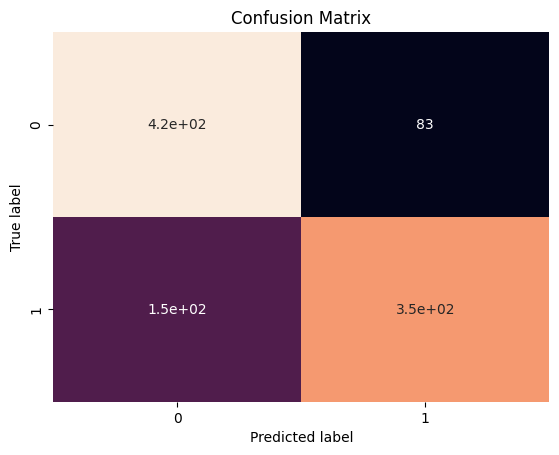

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       500
           1       0.81      0.69      0.75       500

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000

__________ec__________
Accuracy 0.913
Precision: 0.992000
Recall: 0.856649
F1 score: 0.919370


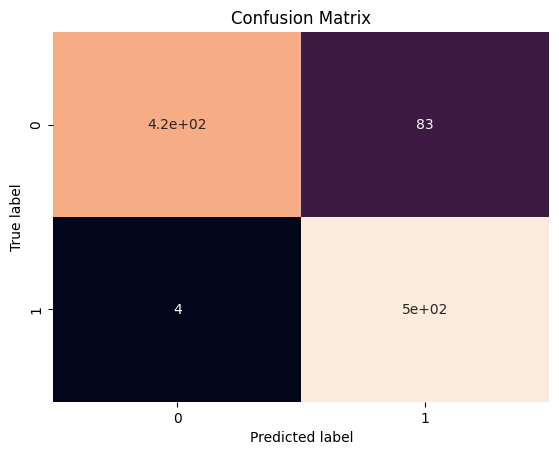

              precision    recall  f1-score   support

           0       0.99      0.83      0.91       500
           1       0.86      0.99      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000

__________vqvae__________
Accuracy 0.893
Precision: 0.952000
Recall: 0.851521
F1 score: 0.898961


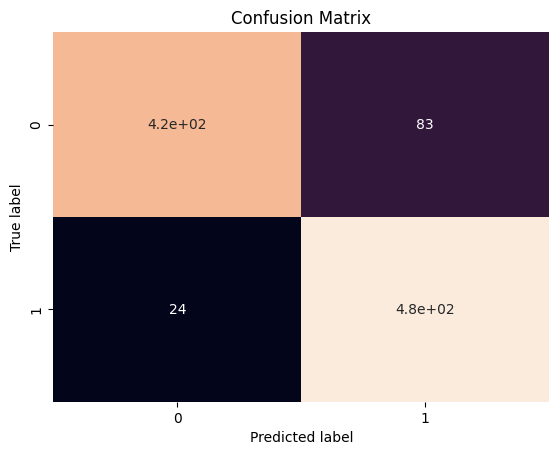

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000

__________ 101_freeze __________
__________gen__________
Accuracy 0.578
Precision: 0.562000
Recall: 0.580579
F1 score: 0.571138


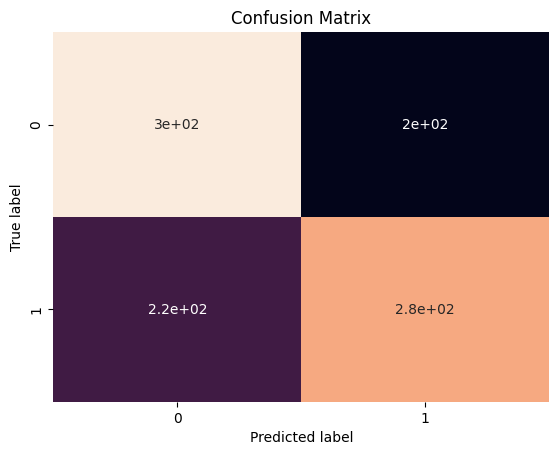

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       500
           1       0.58      0.56      0.57       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000

__________ec__________
Accuracy 0.693
Precision: 0.792000
Recall: 0.661102
F1 score: 0.720655


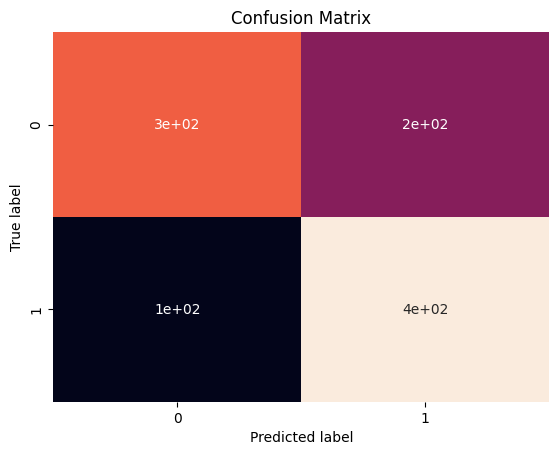

              precision    recall  f1-score   support

           0       0.74      0.59      0.66       500
           1       0.66      0.79      0.72       500

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000

__________vqvae__________
Accuracy 0.542
Precision: 0.490000
Recall: 0.546875
F1 score: 0.516878


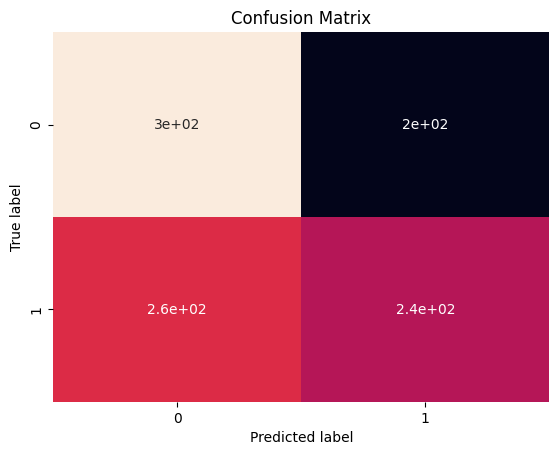

              precision    recall  f1-score   support

           0       0.54      0.59      0.56       500
           1       0.55      0.49      0.52       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

__________ 50_freeze __________
__________gen__________
Accuracy 0.589
Precision: 0.514000
Recall: 0.604706
F1 score: 0.555676


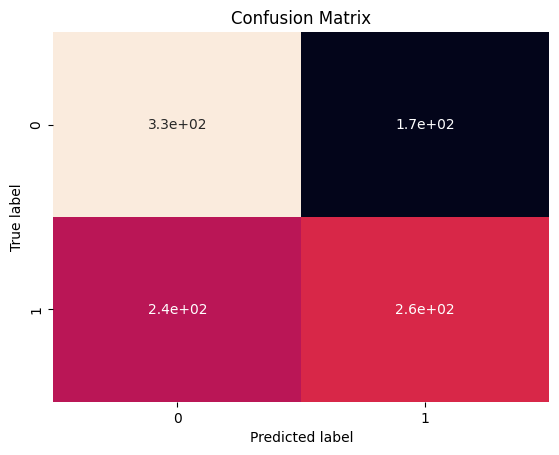

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       500
           1       0.60      0.51      0.56       500

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000

__________ec__________
Accuracy 0.732
Precision: 0.800000
Recall: 0.704225
F1 score: 0.749064


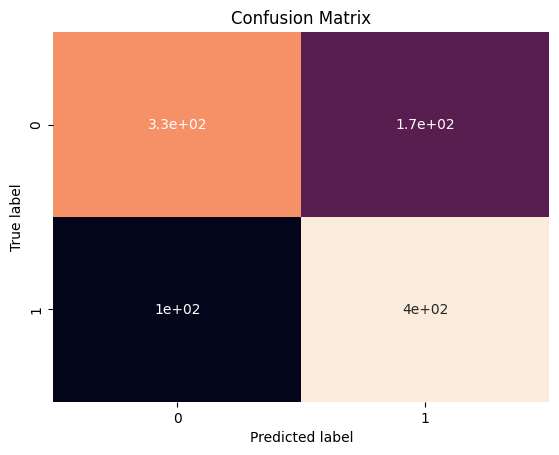

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       500
           1       0.70      0.80      0.75       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000

__________vqvae__________
Accuracy 0.576
Precision: 0.488000
Recall: 0.592233
F1 score: 0.535088


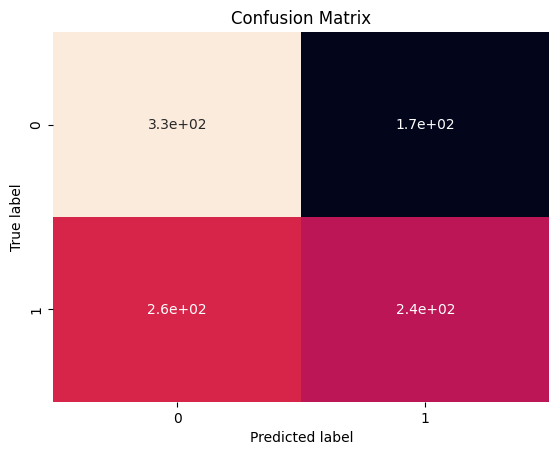

              precision    recall  f1-score   support

           0       0.56      0.66      0.61       500
           1       0.59      0.49      0.54       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.57      1000
weighted avg       0.58      0.58      0.57      1000



In [24]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))